In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import os
import matplotlib.pyplot as plt 
from scipy import interpolate
import random
import math
import torch
import copy
import time

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, accuracy_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyClassifier
from sklearn import metrics
from sklearn.svm import SVC

import torch
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, TensorDataset

import mads_dl

from PIL import Image
from IPython.display import Image
import matplotlib.cm as cm
import seaborn as sns
torch.manual_seed(1)
from classes import *
# set all columns to be displayed
pd.set_option('display.max_columns', None)

loaddata = LoadData()


# Classes

## Loading Data Classes

In [2]:
# 'FA_20231206_2H_yeast_Pyruvate-d3_1.ser.csv'
# 'FA_20240517_2H_yeast_Nicotinamide-d4 _9.csv'
# 'FA_20240213_2H_yeast_Fumarate-d2_9.csv
file = str(Path('FA_20231123_2H Yeast_Fumarate-d2_12 .csv'))
substrates = loaddata.get_substrate_list(file)
metabolites = loaddata.get_metabolite_list(file)
substrates = [float(i) for i in substrates]
metabolites = [float(i) for i in metabolites]
path_list = loaddata.load_data(file)

In [3]:
print(substrates, metabolites)

[6.653, 4.7] [4.368, 2.474]


# Step 1: Loading the data

In [4]:
# shapes of all the csv files
path_list2 = loaddata.load_data('.csv')

for path in path_list2:
    df = pd.read_csv(path)
    print(df.shape)

(706, 131)
(1418, 238)
(776, 236)
(1045, 131)
(1297, 131)
(1178, 237)
(1594, 131)
(941, 238)
(1503, 131)
(608, 238)
(718, 238)
(654, 51)
(691, 236)
(1429, 131)
(880, 131)
(1074, 131)
(966, 51)
(681, 236)
(1583, 131)
(755, 131)
(877, 40)
(1023, 51)
(1279, 131)
(971, 237)
(799, 131)
(908, 51)
(1527, 131)
(636, 237)
(2268, 131)
(632, 51)
(779, 131)
(1796, 101)
(823, 131)
(2122, 131)
(1139, 181)
(1632, 131)
(890, 237)
(735, 131)
(951, 131)
(793, 236)
(921, 131)
(837, 238)
(1045, 181)
(1170, 236)
(778, 51)
(843, 238)
(898, 51)
(2003, 131)
(695, 131)
(577, 236)
(861, 151)
(653, 131)
(1147, 51)
(645, 238)
(655, 236)
(1063, 51)
(679, 151)
(841, 41)
(925, 71)
(622, 236)
(2072, 131)
(537, 236)
(1675, 131)
(673, 236)
(782, 236)
(1480, 237)
(957, 131)
(1675, 131)
(855, 131)
(960, 131)
(859, 236)
(1226, 131)
(585, 236)
(806, 151)


In [5]:
for file in path_list:
    df = pd.read_csv(file)
    print(df.shape)

(2268, 131)


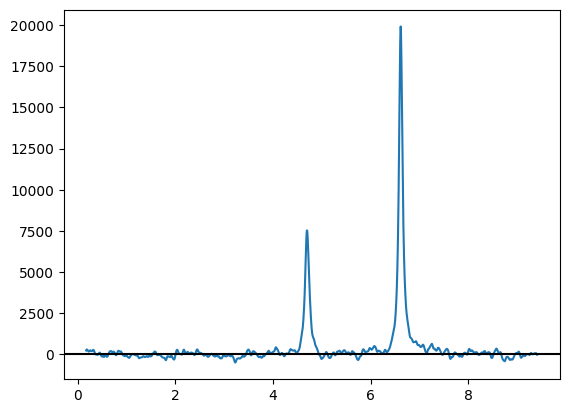

In [6]:
for i in range(len(path_list)):
    df = pd.read_csv(path_list[i])
    

    x = df.iloc[:,0]
    y = df.iloc[:, 1]

    #print(df.shape)

    plt.plot(x,y)

# show x  lines
plt.axhline(y=0, color='k')
plt.show()

# Step 2: Generating synthetic Data for - FA_20231113_2H_yeast_Pyruvate-d3_1.csv

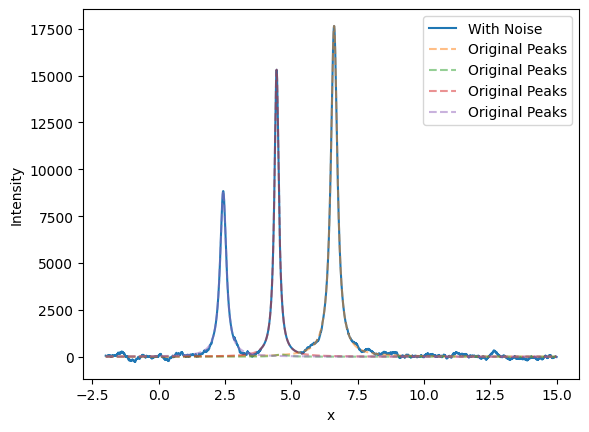

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

# Lorentzian function
def lorentzian(x, x0, gamma, height):
    return height * (gamma**2 / ((x - x0)**2 + gamma**2))


def generate_random_spectrum(peak_list, spectrum_length=3000):

    # Generate random spectrum with Lorentzian peaks
    x = np.linspace(-2, 15, spectrum_length)  # x range
    y = np.zeros_like(x)          # initialize y as zeros
    mask = np.zeros_like(x)       # mask to identify peak regions

    # Add random Lorentzian peaks
    x0_parms = []
    gamma_parms = []
    height_parms = []

    x0_substrate_parms = []
    gamma_substrate_parms = []
    height_substrate_parms = []

    for peak_pos in peak_list:
        metabolism_x0 = peak_pos + np.random.uniform(-0.1, 0.1)
        
        metabolism_gamma = np.random.uniform(0.01, 0.3)  # Random width (gamma)
        metabolism_height = np.random.uniform(100, df.max().max())  # Random height
        peak_lorenz = lorentzian(x, metabolism_x0, metabolism_gamma, metabolism_height)
        y = np.maximum(y, peak_lorenz)  # Use maximum to avoid summing peaks

        # Create a mask to identify regions near the peaks (exclude noise here)
        mask += peak_lorenz > (0.1 * metabolism_height)  # Masking regions where peak height is significant

        # Append the parameters for the peak
        x0_parms.append(metabolism_x0)
        gamma_parms.append(metabolism_gamma)
        height_parms.append(metabolism_height)



    # Add noise only outside the peak regions
    random_noise_level = np.random.uniform(0, df.max().max())
    gaussian_noise = np.random.normal(0, 500, 3000)
    laplace_noise = np.random.laplace(0, 500, 3000)

    # choose random between noise1 and noise2
    noise = gaussian_noise if np.random.rand() > 0.5 else laplace_noise

    #noise = np.random.normal(10, random_noise_level, spectrum_length)

    # smooth the noise with gaussian filter
    sigma = random_noise_level /1
    #noise = gaussian_filter1d(noise, sigma=sigma)
    # rollwing window mean
    noise = np.convolve(noise, np.ones(50)/50, mode='same')
    
    
        
    y_noisy = y + noise * (mask == 0)  # Add noise only where mask is 0 (outside peaks)

    return x, y_noisy, np.array(x0_parms), np.array(gamma_parms), np.array(height_parms)


# ----

#peak_list = [2.323, 4.7, 1.201]
substrates_list = substrates + metabolites
x, y_noisy, x0_parms, gamma_parms, height_parms = generate_random_spectrum(substrates_list)

# Plot the result
plt.plot(x, y_noisy, '-', label="With Noise")

for x0, gamma, height in zip(x0_parms, gamma_parms, height_parms):
    lorentz = lorentzian(x, x0, gamma, height)
    plt.plot(x, lorentz, '--', label="Original Peaks", alpha=0.5)  
plt.xlabel('x')
plt.ylabel('Intensity')
plt.legend()
plt.show()


# Step 3: Fill Up Original Data 

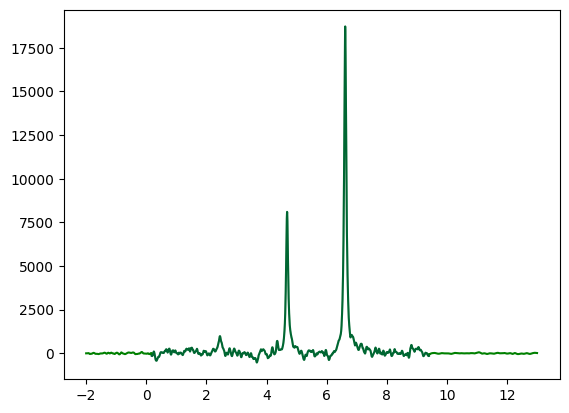

(3686, 2)


,x,y
0,-2.000000,-1.645884
1,-1.995927,-1.746813
2,-1.991855,-1.939760
3,-1.987782,-2.177135
4,-1.983710,-2.429128
...,...,...
3681,12.983526,17.566083
3682,12.987599,16.966044
3683,12.991671,16.513535
3684,12.995744,16.206652


In [8]:



def interpolate_to_shape(x_original, y_original, spectrum_lenth=3000):
    """_summary_

    # Originaldaten
    y_original = df.iloc[:, 1]
    x_original = df.iloc[:, 0]

    Args:
        df (_type_): _description_
    """


    # Neue x-Werte (stellen Sie sicher, dass diese innerhalb des Bereichs von x_original liegen)
    x_new = np.linspace(x_original.min(), x_original.max(), spectrum_lenth)

    # Interpolierte Daten
    interpolated_data = interpolate.interp1d(x_original, y_original, kind='linear')(x_new)
    
    df = pd.DataFrame({'x': x_new, 'y': interpolated_data})
    return df

def fill_df(df):
    """If Data is not ranging from -2 to 10, fill the data with noise
    
    """
    # renmame the columns
    df.columns = ['x', 'y']
    x = df.loc[:, 'x']
    y = df.loc[:, 'y']



    # Calculate the step size of the x values
    x_diff = np.diff(x)
    step = np.mean(x_diff)
    
    # Take sample range for the noise
    x_range_lower = 0
    x_range_upper = 100

    # get sample data of the noise
    x_sample = x[x_range_lower:x_range_upper]
    y_sample = y[x_range_lower:x_range_upper]

    # get the max and min values of the sample data
    y_min, y_max = (y_sample.min()), abs(y_sample.max())
    #print(y_min, y_max)

    # get the min max of the x values
    x_min, x_max = x.min(), x.min()

    if x_min > -2:


        # create values in n steps
        x_new = np.arange(-2, x.iloc[0], step)
        y_new = np.zeros_like(x_new)

        # set the noise level
        noise = np.random.normal(0, y_max, len(x_new))


        
        # smooth the noise with gaussian filter
        # Berechne die Standardabweichung der y-Daten
        sigma = len(y_new) / 100
        noise = gaussian_filter1d(input=noise, sigma=sigma)

        # replace y_new with noise
        y_new = noise

        data = pd.DataFrame({'x': x_new, 'y': y_new})
        df = pd.concat([data, df], axis=0)
        df.reset_index(drop=True, inplace=True)

    if x_max < 15:
    
        # create values in n steps
        x_new = np.arange(x.iloc[-1], 13, step)
        #print(x_new)
        y_new = np.zeros_like(x_new)

        # set the noise level
        noise = np.random.normal(0, y_max, len(x_new))

        # smooth the noise with gaussian filter
        # Berechne die Standardabweichung der y-Daten
        sigma = len(y_new) / 100
        noise = gaussian_filter1d(input=noise, sigma=sigma)

        # replace y_new with noise
        y_new = noise

        data = pd.DataFrame({'x': x_new, 'y': y_new})
        df = pd.concat([df, data], axis=0)
        df.reset_index(drop=True, inplace=True)
                
    return df


df_fill = df.iloc[:, [0, 2]]
#print(df_fill.head())
df_filled = fill_df(df_fill)
#print(df_filled.head())

# plot 
plt.plot(df_filled.iloc[:, 0], df_filled.iloc[:, 1], color='green')
plt.plot(df_fill.iloc[:, 0], df_fill.iloc[:, 1], color='blue', alpha=0.2)
plt.show()
print(df_filled.shape)
display(df_filled)

# Step 3: Bring data to same shape

(3000, 2)


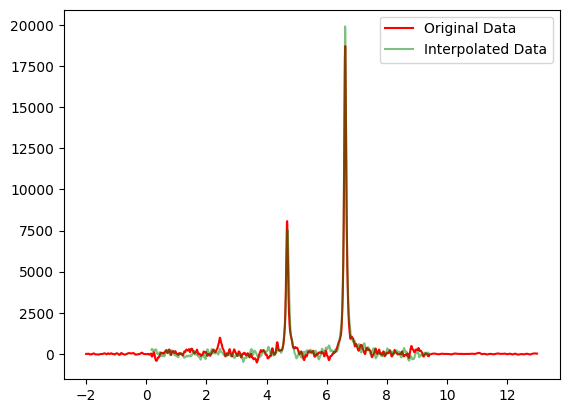

In [9]:

# Interpoliere die Werte, um die Größe des DataFrames zu erweitern
df_interpolated = interpolate_to_shape(df_filled.iloc[:, 0], df_filled.iloc[:, 1], spectrum_lenth=3000)

# Form des interpolierten DataFrames
print(df_interpolated.shape)

# Plot the interpolated data
#plt.plot(df_filled.iloc[:, 0], df_filled.iloc[:, 1])
plt.plot(df_interpolated.iloc[:, 0], df_interpolated.iloc[:, 1], color='red',)
plt.plot(df.iloc[:, 0], df.iloc[:, 1], color='green', alpha=0.5)
plt.legend(['Original Data', 'Interpolated Data', 'Sum'])
plt.show()

# Step 4: Bring Data to shape for Transformer

In [10]:
df_interpolated.shape

(3000, 2)

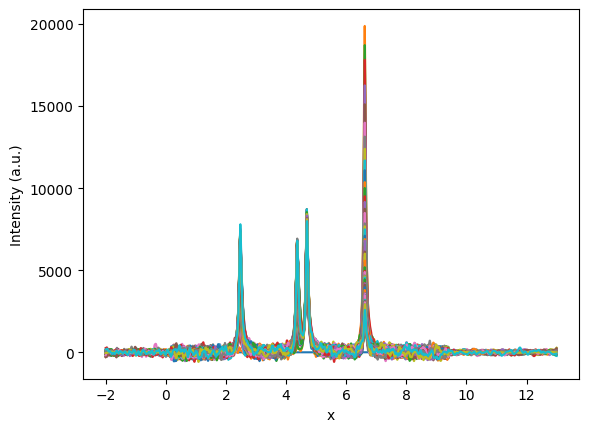

In [11]:
for i in range(df.shape[1]-1):

    df_filled = fill_df(df.iloc[:, [0, i]])
    df_interpolated = interpolate_to_shape(df_filled.loc[:,'x'], df_filled.loc[:,'y'], spectrum_lenth=3000)
    #plt.plot(df_filled.loc[:,'x'], df_filled.loc[:,'y'], '-', label='Original Data')
    plt.plot(df_interpolated.iloc[:, 0], df_interpolated.iloc[:, 1], '-', label='Interpolated Data')

# data_train_tensor & y_train
substrates_list = substrates + metabolites
x_synth, y_synth, x0_parms, gamma_parms, height_parms = generate_random_spectrum(substrates_list)


#plt.plot(x_synth, y_synth, label="With Noise")
plt.xlabel('x')
plt.ylabel('Intensity (a.u.)')

plt.show()

# Generate training Dataset 

In [12]:

num_samples = 5000

x_data = []
y_data = []
x0_parms_list = []
gamma_parms_list = []
height_parms_list = []
for i in range(num_samples):
    # data_train_tensor & y_train
    substrates_list = substrates + metabolites
    x, y_noisy, x0_parms, gamma_parms, height_parms = generate_random_spectrum(substrates_list)
    x_data.append(x)
    y_data.append(y_noisy)
    x0_parms_list.append(x0_parms)
    gamma_parms_list.append(gamma_parms)
    height_parms_list.append(height_parms)




# Umwandeln der lists in Tensoren
x_data = torch.tensor(x_data)
data = torch.tensor(y_data) # Data: Noisy Spectra which is input to the model
x_params_tensor = torch.tensor(x0_parms_list) # Target: 
gamma_params_tensor = torch.tensor(gamma_parms_list)
height_params_tensor = torch.tensor(height_parms_list)

target = torch.cat((x_params_tensor, gamma_params_tensor, height_params_tensor), dim=1)



# Überprüfen der Formen
print(f"x_data shape: {x_data.shape}")
print(f"data shape: {data.shape}")
print(f"x_params_tensor shape: {x_params_tensor.shape}")
print(f"gamma_params_tensor shape: {gamma_params_tensor.shape}")
print(f"height_params_tensor shape: {height_params_tensor.shape}")
print(f"target shape: {target.shape}")
print('\n')

/var/folders/zf/vdfq8dnn2yj6j643_88nnsk80000gn/T/ipykernel_92259/809751612.py:22: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  x_data = torch.tensor(x_data)


x_data shape: torch.Size([5000, 3000])
data shape: torch.Size([5000, 3000])
x_params_tensor shape: torch.Size([5000, 4])
gamma_params_tensor shape: torch.Size([5000, 4])
height_params_tensor shape: torch.Size([5000, 4])
target shape: torch.Size([5000, 12])




In [13]:

def scale_data(data, target):
    """Scale the data
    
    Args:
        x_data (_type_): _description_
        y_data (_type_): _description_
    """
    # Skalieren Sie die Daten
    data_scaler = MinMaxScaler()
    target_scaler = MinMaxScaler()

    print(f'Before Scaling: {data.shape}')
    print(f'Before Scaling: {target.shape}')

    # Reshape the data before scaling
    data = data.reshape(data.shape[0], -1)
    target = target.reshape(target.shape[0], -1)

    print(f'After Reshaping: {data.shape}')
    print(f'After Reshaping: {target.shape}')

    # Skalieren Sie die x-Daten
    data_scaled = data_scaler.fit_transform(data)
    target_scaled = target_scaler.fit_transform(target)
    
    print(f'After Scaling: {data_scaled.shape}')
    print(f'After Scaling: {target_scaled.shape}')


    return data_scaled, target_scaled, data_scaler, target_scaler
    

# Skalieren Sie die Daten
data_scaled, target_scaled, data_scaler, target_scaler = scale_data(data, target)

Before Scaling: torch.Size([5000, 3000])
Before Scaling: torch.Size([5000, 12])
After Reshaping: torch.Size([5000, 3000])
After Reshaping: torch.Size([5000, 12])
After Scaling: (5000, 3000)
After Scaling: (5000, 12)


In [14]:
from sklearn.model_selection import train_test_split
import torch
from sklearn.preprocessing import MinMaxScaler
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



# Aufteilen der Daten in Trainings- und Testsets
data_train, data_tmp, target_train, target_tmp = train_test_split(data, target, 
                                                    test_size=0.4,
                                                    shuffle=True,
                                                    random_state=1)
data_val, data_test, target_val, target_test = train_test_split(data_tmp, target_tmp,
                                                    test_size=0.5,
                                                    shuffle=True,
                                                    random_state=1)

# import StandardScaler
from sklearn.preprocessing import StandardScaler

# Skalieren der Daten
data_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

# Skalieren von data train und test
data_train_sc = data_scaler.fit_transform(data_train)
data_val_sc = data_scaler.transform(data_val)
data_test_sc = data_scaler.transform(data_test)

# Skalieren von target train und test
target_train_sc = target_scaler.fit_transform(target_train)
target_val_sc = target_scaler.transform(target_val)
target_test_sc = target_scaler.transform(target_test)


# Konvertieren in Tensoren
data_train_tensor = torch.tensor(data_train_sc, dtype=torch.float32)
data_val_tensor = torch.tensor(data_val_sc, dtype=torch.float32)
data_test_tensor = torch.tensor(data_test_sc, dtype=torch.float32)
target_train_tensor = torch.tensor(target_train_sc, dtype=torch.float32)
target_val_tensor = torch.tensor(target_val_sc, dtype=torch.float32)
target_test_tensor = torch.tensor(target_test_sc, dtype=torch.float32)





# # Reshape the tensors for the model
# target_train_tensor = target_train_tensor.reshape(target_train_tensor.shape[0], -1)
# target_val_tensor = target_val_tensor.reshape(target_val_tensor.shape[0], -1)

# Überprüfen der Tensoren
print(f"Data Train Shape: {data_train_tensor.shape}")
print(f"Data Val Shape: {data_val_tensor.shape}")
print(f"Data Test Shape: {data_test_tensor.shape}")
print(f"Target Train Shape: {target_train_tensor.shape}")
print(f"Target Val Shape: {target_val_tensor.shape}")
print(f"Target Test Shape: {target_test_tensor.shape}")

Data Train Shape: torch.Size([3000, 3000])
Data Val Shape: torch.Size([1000, 3000])
Data Test Shape: torch.Size([1000, 3000])
Target Train Shape: torch.Size([3000, 12])
Target Val Shape: torch.Size([1000, 12])
Target Test Shape: torch.Size([1000, 12])


# LSTM 

In [15]:
# class NeuralNetwork(nn.Module):
#     def __init__(self, input_size, hidden_size, output_size, dropout_prob):
#         super(NeuralNetwork, self).__init__()

#         self.reduce = nn.Linear(3000, hidden_size)

#         # Define LSTM with correct hidden size
#         self.lstm = nn.GRU(input_size=input_size, hidden_size=hidden_size, num_layers=2, batch_first=True)

#         # Fully connected layers with corrected input sizes
#         self.fc1 = nn.Sequential(
#             nn.Linear(hidden_size, 128),  # Match hidden_size with the output of LSTM
#             nn.LeakyReLU(),
#             nn.Dropout(p=dropout_prob)
#         )

#         self.fc2 = nn.Sequential(
#             nn.Linear(128, 32),
#             nn.LeakyReLU(),
#             nn.Dropout(p=dropout_prob)
#         )

#         self.fc3 = nn.Sequential(
#             nn.Linear(32, 16),
#             nn.LeakyReLU(),
#             nn.Dropout(p=dropout_prob)
#         )

#         # Output layer
#         self.output = nn.Linear(16, output_size)

#     def forward(self, x):
#         # Check shape before reducing
#         #print(f"Input shape before reduction: {x.shape}")  # For debugging
#         x = self.reduce(x)  # This should expect (batch_size, 3000)
        

#         # Reshape for LSTM input
#         x = x.reshape(x.shape[0], 1, -1)  # Reshape to (batch_size, seq_len, input_size)
#         #print(f"Shape after reduction: {x.shape}")

#         batch_size = x.shape[0]
        
#         # Initialize hidden and cell states with hidden_size instead of input_size
#         h_0 = torch.zeros(2, batch_size, hidden_size).to(x.device)
#         #c_0 = torch.zeros(2, batch_size, hidden_size).to(x.device)

#         # Pass data through LSTM
#         x, _ = self.lstm(x, (h_0))
#         x = x[:, -1, :]  # Take the output from the last time step

#         # Pass data through fully connected layers
#         x = self.fc1(x)
#         x = self.fc2(x)
#         x = self.fc3(x)

#         # Final output
#         output = self.output(x)
#         return output
    
#     def predict(self, X):
#         '''
#         Use the model to predict for the values in the test set.
#         Return the prediction
#         '''
#         model.eval()
#         with torch.no_grad():
#             return model(X)


In [16]:
print(data_train_tensor.shape, target_train_tensor.shape)

torch.Size([3000, 3000]) torch.Size([3000, 12])


# Conv1D

In [17]:
# import torch
# import torch.nn as nn

# class NeuralNetwork(nn.Module):
#     def __init__(self, input_size, hidden_size, output_size, dropout_prob):
#         super(NeuralNetwork, self).__init__()
        
#         self.firstpooling = nn.Sequential(
#             nn.AvgPool1d(kernel_size=2, stride=2, padding=0),
#             nn.Dropout(p=dropout_prob),
#             nn.LeakyReLU()
#         )
#         # Convolutional and pooling layers  
#         self.conv1 = nn.Sequential(
#             nn.Conv1d(in_channels=1, out_channels=8, kernel_size=3, stride=1, padding=1),
#             nn.LeakyReLU(),
#             nn.Dropout(p=dropout_prob),
#             nn.MaxPool1d(kernel_size=2, stride=2, padding=0)
#         )
        
        
#         self.conv2 = nn.Sequential(
#             nn.Conv1d(in_channels=8, out_channels=8, kernel_size=3, stride=1, padding=1),
#             nn.LeakyReLU(),
#             nn.Dropout(p=dropout_prob),
#             nn.MaxPool1d(kernel_size=2, stride=2, padding=0)
#         )
        

#         # Fully connected layers
#         self.fc1 = nn.Sequential(
#             nn.Linear(3000, 1000),  # Adjust for pooling effects
#             nn.LeakyReLU(),
#             nn.Dropout(p=dropout_prob)
#         )

#         self.fc2 = nn.Sequential(
#             nn.Linear(1000, 128),
#             nn.LeakyReLU(),
#             nn.Dropout(p=dropout_prob)
#         )

#         self.fc3 = nn.Sequential(
#             nn.Linear(3000, 32),
#             nn.LeakyReLU(),
#             nn.Dropout(p=dropout_prob)
#         )

#         # Output layer
#         self.output = nn.Linear(32, output_size)

#     def forward(self, x):
#         # Apply convolutional layers with pooling
        
#         x = x.unsqueeze(1)
#         x = self.firstpooling(x)
#         x = self.conv1(x)      
#         x = self.conv2(x)  

#         #print(x.shape)
#         # Flatten the output for fully connected layers
#         x = x.reshape(x.shape[0], -1)        
#         # Pass through fully connected layers
#         # x = self.fc1(x)
#         # x = self.fc2(x)
#         x = self.fc3(x)

#         # Output layer
#         output = self.output(x)
#         return output

#     def predict(self, X):
#         self.eval()
#         with torch.no_grad():
#             return self(X)


In [18]:
# import torch
# import torch.nn as nn
# import math

# class NeuralNetwork(nn.Module):
#     def __init__(self, 
#                  input_size=3000, 
#                  hidden_size=128, 
#                  output_size=27, 
#                  dropout_prob=0.2,
#                  avgpool_kernel_size=2,
#                  avgpool_stride=2,
#                  avgpool_padding=0,

#                  conv1_in_channels=1,
#                  conv1_out_channels=8,
#                  conv1_kernel_size=3,
#                  conv1_stride=1,
#                  conv1_padding=1,

#                  conv2_in_channels=8,
#                  conv2_out_channels=12,
#                  conv2_kernel_size=3,
#                  conv2_stride=1,
#                  conv2_padding=1,
#                  fc1_out_features=128,
                
#                  fc3_out_features=32):
#         super(NeuralNetwork, self).__init__()
        
#         # Pooling and activation
#         self.firstpooling = nn.Sequential(
#             nn.AvgPool1d(kernel_size=avgpool_kernel_size, stride=avgpool_stride, padding=avgpool_padding),
#             nn.Dropout(p=dropout_prob),
#             nn.LeakyReLU()
#         )

#         # Convolutional and pooling layers  
#         self.conv1 = nn.Sequential(
#             nn.Conv1d(in_channels=conv1_in_channels, out_channels=conv1_out_channels, 
#                       kernel_size=conv1_kernel_size, stride=conv1_stride, padding=conv1_padding),
#             nn.LeakyReLU(),
#             nn.Dropout(p=dropout_prob),
#             nn.MaxPool1d(kernel_size=2, stride=2, padding=0)
#         )

#         # self.conv2 = nn.Sequential(
#         #     nn.Conv1d(in_channels=conv1_out_channels, out_channels=conv2_out_channels, 
#         #               kernel_size=conv2_kernel_size, stride=conv2_stride, padding=conv2_padding),
#         #     nn.LeakyReLU(),
#         #     nn.Dropout(p=dropout_prob),
#         #     nn.MaxPool1d(kernel_size=2, stride=2, padding=0)
#         # )

#         # Compute output size after convolution and pooling
#         def compute_output_size(input_len, kernel_size, stride, padding, layers=1):
#             for _ in range(layers):
#                 input_len = math.floor((input_len + 2 * padding - (kernel_size - 1) - 1) / stride + 1)
#             return input_len

#         pooled_size = compute_output_size(input_size, avgpool_kernel_size, avgpool_stride, avgpool_padding)
#         conv1_size = compute_output_size(pooled_size, conv1_kernel_size, conv1_stride, conv1_padding)
#         conv1_pooled = math.floor(conv1_size / 2)  # Max pooling halves the size
#         conv2_size = compute_output_size(conv1_pooled, conv2_kernel_size, conv2_stride, conv2_padding)
#         conv2_pooled = math.floor(conv2_size / 2)  # Max pooling halves the size again

#         flattened_size = conv1_out_channels * conv1_pooled

#         # # Fully connected layers
#         # self.fc1 = nn.Sequential(
#         #     nn.Linear(flattened_size, fc1_out_features),
#         #     nn.LeakyReLU(),
#         #     nn.Dropout(p=dropout_prob)
#         # )

#         self.fc2 = nn.Sequential(
#             nn.Linear(flattened_size, fc3_out_features),
#             nn.LeakyReLU(),
#             nn.Dropout(p=dropout_prob)
#         )

#         # Output layer
#         self.output = nn.Linear(fc3_out_features, output_size)

#     def forward(self, x):
#         x = x.unsqueeze(1)  # Add channel dimension
#         x = self.firstpooling(x)
#         x = self.conv1(x)
#         #x = self.conv2(x)
#         x = x.reshape(x.shape[0], -1)  # Flatten
#         #x = self.fc1(x)
#         x = self.fc2(x)
#         output = self.output(x)

#         return output

#     def predict(self, X):
#         self.eval()
#         with torch.no_grad():
#             return self(X)

# Linear Layer

In [19]:
class NeuralNetwork(nn.Module):
    
    def __init__(self, 
                 input_size=3000, 
                 fc1_output=512, 
                 output_size=len(substrates_list) * 3, 
                 dropout_prob=0.1,
                 kernel_size=2,
                 stride=1,
                 padding=1
                 ):
        

        super(NeuralNetwork, self).__init__()

        self.pooling = nn.Sequential(
            nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=padding)
        )
        reduced_size = (input_size + 2 * padding - kernel_size) // stride + 1
        self.fc1 = nn.Sequential(
            nn.Linear(reduced_size, fc1_output),
            nn.LeakyReLU(),
            nn.Dropout(p=dropout_prob)
        )


        # Output layer
        self.output = nn.Linear(fc1_output, output_size)

    def forward(self, x):
        x = self.pooling(x)

        x = self.fc1(x)
        output = self.output(x)
        return output

    def predict(self, X):
        self.eval()
        with torch.no_grad():
            return self(X)

# Training

In [20]:

def calculate_mse_of_real_data(df, model, random=True, i = 3, tensor=False):

    """
    e.g. df: df.iloc[:, [0, 1]]
    """

    if random:
        i = np.random.randint(1, df.shape[1])

    # fill the data
    df_fill = fill_df(df.iloc[:, [0, i]])

    # interpolate the data
    df_interpolated = interpolate_to_shape(df_fill.iloc[:, 0], df_fill.iloc[:, 1], spectrum_lenth=3000)
    #display(df_interpolated)
    x_real = df_interpolated.loc[:, 'x']
    y_real = df_interpolated.loc[:, 'y']

    # scale the data
    y_real_sc = data_scaler.transform(y_real.values.reshape(1, -1))


    # convert to tensor
    y_real_tensor = torch.tensor(y_real_sc, dtype=torch.float32).to(device)

    # predict the data
    target_real_pred = model.predict(y_real_tensor)

    if tensor == True:
        print(target_real_pred)

    # bring the data back to the cpu
    target_real_pred_cpu = target_real_pred.cpu().detach().numpy()

    # rescale the data
    target_real_pred_rescaled = target_scaler.inverse_transform(target_real_pred_cpu)

    # reshape the data
    target_real_pred = target_real_pred_rescaled.reshape(target_real_pred_rescaled.shape[0], -1)

    x0_parms_real, gamma_parms_real, height_parms_real = np.split(target_real_pred, 3, axis=1)

        

    # Put the Lorenz functions in a Dataframe
    lorentz_list = []
    lorentz_df = pd.DataFrame({'x': x_real})  # Initialize DataFrame with x_real

    for i, (x0, gamma, height) in enumerate(zip(x0_parms_real[0], gamma_parms_real[0], height_parms_real[0])):
        lorentz = lorentzian(x_real, x0, gamma, height)
        column_name = f'lorentz_{i}'  # Dynamically generate a unique column name
        lorentz_df = pd.concat([lorentz_df, pd.DataFrame({column_name: lorentz})], axis=1)

    # add another column which takes the np.maximum of the columns
    lorentz_df['max'] = lorentz_df.iloc[:, 1:].max(axis=1)
    #display(lorentz_df)

    # calculate the mse between the real data and lorentz_df
    mse = mean_squared_error(y_real, lorentz_df['max'])
    return mse

In [45]:
def calculate_mse_of_real_data_loss(df, model, random=True, i=3, device='cpu'):
    """
    Calculate MSE of real data, ensuring it can be used for backpropagation.
    """
    if random:
        i = np.random.randint(1, df.shape[1])

    # Fill the data
    df_fill = fill_df(df.iloc[:, [0, i]])

    # Interpolate the data
    df_interpolated = interpolate_to_shape(df_fill.iloc[:, 0], df_fill.iloc[:, 1], spectrum_lenth=3000)
    x_real = torch.tensor(df_interpolated['x'].values, dtype=torch.float32, device=device, requires_grad=False)
    y_real = torch.tensor(df_interpolated['y'].values, dtype=torch.float32, device=device, requires_grad=False)

    # scale the data
    y_real_sc = data_scaler.transform(y_real.numpy().reshape(1, -1))
    


    # convert to tensor
    y_real_tensor = torch.tensor(y_real_sc, dtype=torch.float32, requires_grad=True).to(device)

    # Predict the data
    target_real_pred = model(y_real_tensor)

    # reshape the data
    target_real_pred = target_real_pred.reshape(target_real_pred.shape[0], -1)
    #print(target_real_pred.shape)


    # # Split the predictions
    x0_parms_real, gamma_parms_real, height_parms_real = torch.split(
        target_real_pred, target_real_pred.shape[1] // 3, dim=1
    )
    #print(x0_parms_real.shape)
    # Compute Lorentzian functions
    lorentz_list = []
    for x0, gamma, height in zip(x0_parms_real[0], gamma_parms_real[0], height_parms_real[0]):
        lorentz = lorentzian(x_real, x0, gamma, height)  # Assume lorentzian returns a PyTorch tensor
        lorentz_list.append(lorentz)

    # Stack Lorentzian columns and compute maximum
    lorentz_tensor = torch.stack(lorentz_list, dim=1)
    max_lorentz = torch.max(lorentz_tensor, dim=1).values
    
    # if True:
    #     # Convert to NumPy for plotting
    #     tensor_1d_np = max_lorentz.detach().cpu().numpy()

    #     # Plot
    #     plt.plot(x_real,tensor_1d_np)
    #     plt.title("1D Tensor Line Plot")
    #     plt.xlabel("Index")
    #     plt.ylabel("Value")
    #     plt.show()


    # Compute MSE using PyTorch
    mse = torch.nn.functional.mse_loss(max_lorentz, y_real)



    return mse


In [47]:


# ------------------------------------
import torch

def get_model_size(model):
    total_params = sum(p.numel() for p in model.parameters())
    size_in_bytes = total_params * 4  # Assuming 32-bit (4 bytes) floats
    size_in_megabytes = size_in_bytes / (1024 ** 2)  # Convert to MB
    return total_params, size_in_megabytes


df = pd.read_csv(path_list[0]) 

dropout_results = [] # storing the results of the dropout experiment
optuna_results = [] # storing the results of the optuna experiment

def training(model, X_train, y_train, X_val, y_val, criterion, optimizer, epochs, writer, batch_size=64, patience=20, dropout_prob=0.5, log_tensorboard=True, verbose=True, check_real_data=False):

    # Set device to GPU if available
    if torch.cuda.is_available():
        device = torch.device('cuda')
    else:
        device = torch.device('cpu')

   # device = torch.device('cpu')

    # Move data and model to device
    X_train, y_train, X_val, y_val = X_train.to(device), y_train.to(device), X_val.to(device), y_val.to(device)
    model.to(device)

    # Initialize best metrics and model
    best_eval_metric_val = float('inf') # Initialize the best_eval_metric
    best_val_loss = float('inf') # Initialize the best_val_loss
    best_real_metric_val = float('inf')
    best_model = copy.deepcopy(model.state_dict()) # Initialize the best_model
    patience_counter_loss = 0  # Early stopping counter
    patience_counter_metric = 0  # Early stopping counter

    # DataLoader for batching
    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)


    # Scheduler for learning rate adjustment (if val_loss does not improve for 'patience' epochs)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)
    train_losses, val_losses = [], [] # to visualize the drop_out_prob
    train_accuracies, val_accuracies = [], []
    real_accuracies = []
    # Training Loop
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0

        # Training loop
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)

            
            
            #print(data.shape, target.shape)
            optimizer.zero_grad()  # Clear gradients
            outputs = model(data)  # Forward pass
            #loss = criterion(outputs.squeeze(1), target)  # Calculate loss

            # FOR LSTM
            loss = criterion(outputs, target)  # Calculate loss # For LSTM
            #print(loss)
            loss_real = calculate_mse_of_real_data_loss(df, model, random=True, device=device)
            
            loss_real.backward()  # Backpropagation
            optimizer.step()  # Update weights

            epoch_loss += loss # Accumulate batch loss

        # Validation
        model.eval()
        with torch.no_grad():
            
            val_outputs = model(X_val)  # Forward pass
            #loss_val = criterion(val_outputs.squeeze(1), y_val)
            # FOR LSTM
            loss_val = criterion(val_outputs, y_val)
            scheduler.step(loss_val)  # Adjust learning rate based on loss
            
            # calculate the training mase
            predictions_train = model.predict(X_train)
            
            mse_train = mean_squared_error(y_train.cpu(), predictions_train.cpu().squeeze(1))

            # Calculate validation mase
            predictions_val = model.predict(X_val)
            mse_val = mean_squared_error(y_val.cpu(), predictions_val.cpu().squeeze(1))

            # Calculate the mse of real data
            mse_real = calculate_mse_of_real_data(df, model, random=True)


            # Log to TensorBoard
            if log_tensorboard:
              writer.add_scalars("Loss", {"train": epoch_loss / len(train_loader), 'val': loss_val}, epoch)
              writer.add_scalars("MSE", {"train": mse_train, "val": mse_val}, epoch)
              writer.add_scalars("MSE/Real Data", {"MSE": mse_real}, epoch)
              writer.flush()

            # Early stopping if loss_val is increasing
            if loss_val < best_val_loss:
                best_val_loss = loss_val  # Update best val_loss
                patience_counter_loss = 0  # Reset patience counter
            else:
                patience_counter_loss += 1  # Increment if no improvement

            # Early Stopping based on if val_mse is not increasing
            if mse_val < best_eval_metric_val:
                best_eval_metric_val = mse_val
                #best_model = copy.deepcopy(model.state_dict()) # saves the best model where the rmse_val is highest
                patience_counter_metric_val = 0  # Reset patience counter if improved
            else:
                patience_counter_metric_val += 1

            # early stopping if real_mse is increasing
            if mse_real < best_real_metric_val:
                best_real_metric_val = mse_real
                best_model = copy.deepcopy(model.state_dict()) # saves the best model where the rmse_val is highest
            else:
                patience_counter_metric += 1



            # Early stopping check
            if (patience_counter_loss >= patience) or (patience_counter_metric >= patience):
                print(f"Early stopping at epoch {epoch+1}")
                break


        # Print status
        if verbose:
          if epoch % 19 == 0:
            print(f"| Epoch {epoch+1} | Train Loss: {epoch_loss / len(train_loader):.4f}, Validation Loss: {loss_val:.4f} | Train MSE: {mse_train:.4f}, Val MSE: {mse_val:.4f} |")

        if check_real_data:
            train_losses.append(epoch_loss / len(train_loader))
            val_losses.append(loss_val)
            train_accuracies.append(mse_train)
            val_accuracies.append(mse_val)
            real_accuracies.append(mse_real)

            
            optuna_results.append({'dropout_prob': dropout_prob,
                                    'train_loss': train_losses,
                                    'val_loss': val_losses,
                                    'training_MSE': train_accuracies,
                                    'validation_MSE': val_accuracies,
                                    'real_data_MSE': mse_real
                                    })

            


    dropout_results.append({'dropout_prob': dropout_prob,
                                    'train_loss': train_losses,
                                    'val_loss': val_losses,
                                    'training_MSE': train_accuracies,
                                    'validation_MSE': val_accuracies
                                    })
    # Load the best model
    model.load_state_dict(best_model)
    print(f"Best validation MSE: {best_eval_metric_val:.4f}")
    if check_real_data:
        print(f'MSE Real Data: {mse_real}')

    writer.close()
    return model, optuna_results




#%tensorboard --logdir=runs


# Data preparation: ensure data shapes are correct
data_train_tensor = data_train_tensor.reshape(-1, 3000)  # Assuming original shape is (num_samples, 3000)
data_val_tensor = data_val_tensor.reshape(-1, 3000)

# Check shapes before training
print("Train shape:", data_train_tensor.shape)
print("Validation shape:", data_val_tensor.shape)

#Define model with correct input size
input_size = 3000
hidden_size = 512
output_size = len(substrates_list) * 3
dropout_prob = 0.1
learning_rate = 0.01
epochs = 100

model = NeuralNetwork().to(device)
model_size, model_size_mb = get_model_size(model)
print(f'Total parameters: {model_size}')
print(f'Model size: {model_size_mb:.2f} MB')

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.MSELoss()

writer = SummaryWriter()

trained_model, _ = training(model=model,
                         X_train=data_train_tensor,
                         y_train=target_train_tensor,
                         X_val=data_val_tensor,
                         y_val=target_val_tensor,
                         criterion=criterion,
                         optimizer=optimizer,
                         epochs=epochs,
                         writer=writer,
                         dropout_prob=dropout_prob,
                         log_tensorboard=True,
                         verbose=True,
                         check_real_data=True)


Train shape: torch.Size([3000, 3000])
Validation shape: torch.Size([1000, 3000])
Total parameters: 1543180
Model size: 5.89 MB
| Epoch 1 | Train Loss: 31799.7969, Validation Loss: 47246.5820 | Train MSE: 47007.9648, Val MSE: 47246.5508 |
| Epoch 20 | Train Loss: 32010.5820, Validation Loss: 28346.9648 | Train MSE: 28214.2363, Val MSE: 28346.9668 |
Early stopping at epoch 26
Best validation MSE: 25106.9473
MSE Real Data: 24216689840960.887


In [ ]:
df = pd.read_csv(path_list[0]) 



# Optuna


In [ ]:
# import optuna
# import gc

# def objective(trial):
#     # Suggest hyperparameters
#     dropout_prob = trial.suggest_float('dropout_prob', 0.1, 0.99, step=0.01)
#     learning_rate = trial.suggest_float('learning_rate', 1e-6, 1e-2, log=True)
#     batch_size = trial.suggest_int('batch_size', 4, 1024, step=4)
#     fc1_output = trial.suggest_int('fc1_output', 1, 1000, step=1)

#     kernel_size = trial.suggest_int('kernel_size',20, 150, step=1)
#     stride = trial.suggest_int('stride',1, 10, step=1)
#     padding = trial.suggest_int('padding',1, 10, step=1)
    
#     # Initialize model and optimizer
#     model = NeuralNetwork(
#         input_size=3000, 
#         fc1_output=fc1_output, 
#         output_size=len(substrates_list) * 3, 
#         dropout_prob=dropout_prob,
#         kernel_size=kernel_size,
#         stride=stride,
#         padding = padding
#     ).to(device)
#     optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#     criterion = torch.nn.MSELoss()
#     writer = SummaryWriter(log_dir=f"runs/trial_{trial.number}")
    
#     try:
#         # Train the model
#         trained_model, optuna_results = training(
#             model=model,
#             X_train=data_train_tensor,
#             y_train=target_train_tensor,
#             X_val=data_val_tensor,
#             y_val=target_val_tensor,
#             criterion=criterion,
#             optimizer=optimizer,
#             epochs=1000,
#             writer=writer,
#             dropout_prob=dropout_prob,
#             log_tensorboard=False,
#             verbose=False,
#             check_real_data=True,
#             batch_size=batch_size
#         )
        
#         mse_val = optuna_results[-1]['real_data_MSE']
        
#     finally:
#         # Cleanup
#         writer.close()
#         del model, optimizer
#         torch.cuda.empty_cache()
#         gc.collect()
    
#     return mse_val


# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=200)  # Run for 20 trials (adjust as needed)


In [ ]:
# print(study.best_params)
# print(study.best_value)

In [ ]:
# optuna.visualization.plot_optimization_history(study).show()
# optuna.visualization.plot_param_importances(study).show()
# optuna.visualization.plot_parallel_coordinate(study).show()


In [ ]:
# # Train the model with the best parameters
# best_params = study.best_params
# dropout_prob = best_params['dropout_prob']
# learning_rate = best_params['learning_rate']
# fc1_output = best_params['fc1_output']




# # Define the model with the suggested dropout_prob
# model = NeuralNetwork(
#         input_size=3000, 
#         fc1_output=fc1_output, 
#         output_size=len(substrates_list) * 3, 
#         dropout_prob=dropout_prob
#         ).to(device)

# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# criterion = torch.nn.MSELoss()
# epochs = 1000  # Number of epochs to train

# model, _ = training(
#     model=model,
#     X_train=data_train_tensor,
#     y_train=target_train_tensor,
#     X_val=data_val_tensor,
#     y_val=target_val_tensor,
#     criterion=criterion,
#     optimizer=optimizer,
#     epochs=epochs,
#     writer=SummaryWriter(),
#     dropout_prob=dropout_prob,
#     log_tensorboard=True,
#     verbose=True,
#     check_real_data=True
# )

In [ ]:
# # Bring all tensors back to the CPU
data_train_tensor = data_train_tensor.to("cpu")
data_val_tensor = data_val_tensor.to("cpu")

data_train_tensor.shape

torch.Size([3000, 3000])

In [ ]:
# Vorhersagen und Rückskalierung
model.to("cpu")
target_train_pred = model.predict(data_train_tensor)
target_val_pred = model.predict(data_val_tensor)

# Bring all tensors back to the CPU and to numpy
target_train_pred = target_train_pred.cpu().detach()
target_val_pred = target_val_pred.cpu().detach()
data_train_tensor = data_train_tensor.cpu().detach()
data_val_tensor = data_val_tensor.cpu().detach()


print(f'target_train_pred: {target_train_pred.shape}')
print(f'target_val_pred: {target_val_pred.shape}')


# FOR Linear Model
# Rescale the data
#target_train_pred_rescaled = target_scaler.inverse_transform(target_train_pred.squeeze(1))
#target_val_pred_rescaled = target_scaler.inverse_transform(target_val_pred.squeeze(1))


#for LSTM
# # Rescale the data
target_train_pred_rescaled = target_scaler.inverse_transform(target_train_pred)
target_val_pred_rescaled = target_scaler.inverse_transform(target_val_pred)

# Reshape the data
target_train_pred = target_train_pred_rescaled.reshape(target_train_pred_rescaled.shape[0], -1)
target_val_pred = target_val_pred_rescaled.reshape(target_val_pred_rescaled.shape[0], -1)




print(f'target_train_pred_rescaled: {target_train_pred.shape}')
print(f'target_val_pred_rescaled: {target_val_pred.shape}')

target_train_pred: torch.Size([3000, 12])
target_val_pred: torch.Size([1000, 12])
target_train_pred_rescaled: (3000, 12)
target_val_pred_rescaled: (1000, 12)


In [ ]:
print(len(substrates_list))

4


data_train: (3000, 3000)
data_val: (1000, 3000)
target_train: (3000, 12)
len substrates_list: 4


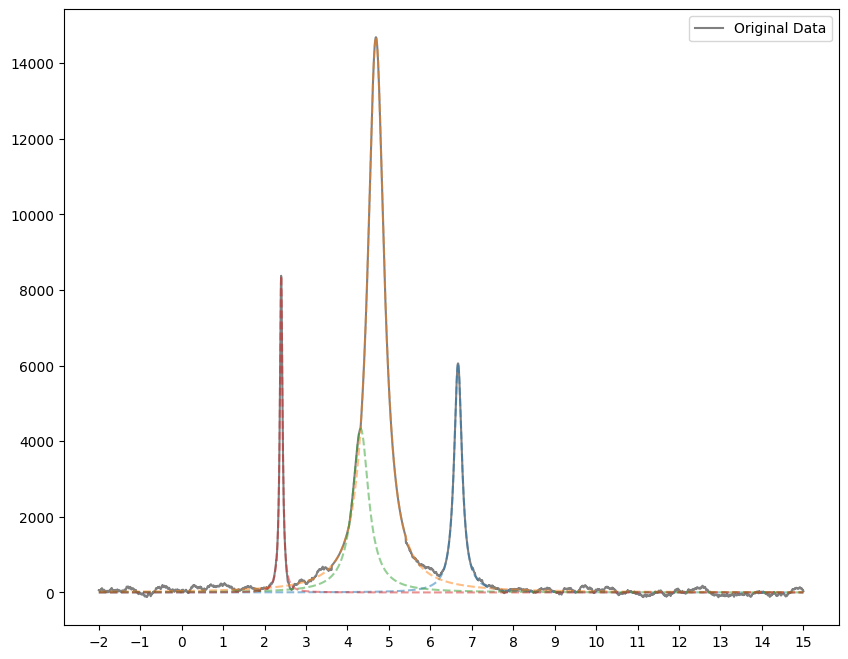

In [ ]:
# bring the data back to the cpu
data_train_tensor = data_train_tensor.to("cpu")
data_val_tensor = data_val_tensor.to("cpu")
data_test_tensor = data_test_tensor.to("cpu")

target_train_tensor = target_train_tensor.to("cpu")
target_val_tensor = target_val_tensor.to("cpu")
target_test_tensor = target_test_tensor.to("cpu")

data_train_tensor = data_train_tensor.squeeze(1)
data_val_tensor = data_val_tensor.squeeze(1)
# scale the data back
data_train = data_scaler.inverse_transform(data_train_tensor)
data_val = data_scaler.inverse_transform(data_val_tensor)
target_train = target_scaler.inverse_transform(target_train_tensor)


print(f'data_train: {data_train.shape}')
print(f'data_val: {data_val.shape}')
print(f'target_train: {target_train.shape}')

print(f'len substrates_list: {len(substrates_list)}')


x0_parms_train, gamma_parms_train, height_parms_train = np.split(target_train, 3, axis=1)
x0_parms_val, gamma_parms_val, height_parms_val = np.split(target_val, 3, axis=1)
x0_parms_test, gamma_parms_test, height_parms_test = np.split(target_test, 3, axis=1)




n = 10
x = x_data[n]
# plot the data
#plt.plot(x, data_train[n, :], '-', label='Original Data')
# for x0, gamma, height in zip(x0_parms_train[n], gamma_parms_train[n], height_parms_train[n]):
#     lorentz = lorentzian(x, x0, gamma, height)
#     plt.plot(x, lorentz, '--', label='Original Peaks', alpha=0.5)

# plt.plot(x, data_val[n, :], '-', label='Original Data', color='grey')
# for x0, gamma, height in zip(x0_parms_val[n], gamma_parms_val[n], height_parms_val[n]):
#     lorentz = lorentzian(x, x0, gamma, height)
#     plt.plot(x, lorentz, '--', label='Original Peaks', alpha=0.5)   
    
fig = plt.figure(figsize=(10, 8))

plt.plot(x, data_test[n, :], '-', label='Original Data', color='grey')
for x0, gamma, height in zip(x0_parms_test[n], gamma_parms_test[n], height_parms_test[n]):
    lorentz = lorentzian(x, x0, gamma, height)
    plt.plot(x, lorentz, '--', alpha=0.5)

plt.xticks(np.arange(-2, 16, 1))
plt.legend()
plt.show()

# Validate on real Data

In [ ]:
# # Use a dataframe to collect general evaluation results
# results = pd.DataFrame()

# # We will reuse this function. Hence we copy it to mads_dl.py
# def add_regression_eval(results, algorithm, y_train, y_train_pred, y_test, y_test_pred, num_params):
#     '''
#     Create a table with evaluation results
#     of a regression experiment
#     '''
#     for dataset, actual, predicted in zip(("train", "test"), (y_train, y_test), (y_train_pred, y_test_pred)):
#         mse=mean_squared_error(actual, predicted)
#         results= pd.concat([results, pd.DataFrame([{
#             "algorithm": algorithm, 
#             "dataset": dataset,
#             "MSE": mse,
#             "RMSE": math.sqrt(mse),
#             "MAE": mean_absolute_error(actual, predicted),
#             "MAPE": mean_absolute_percentage_error(actual, predicted)*100, # implemented is relative to 1 not to 100
#             "params": num_params
#         }])], ignore_index=True)   
#     return results


# Test on Data

(1, 3000)


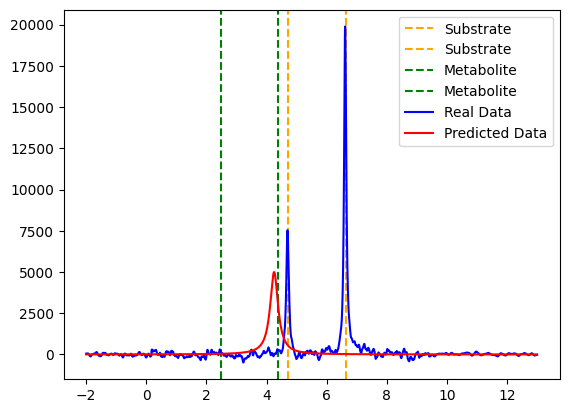

(1, 3000)


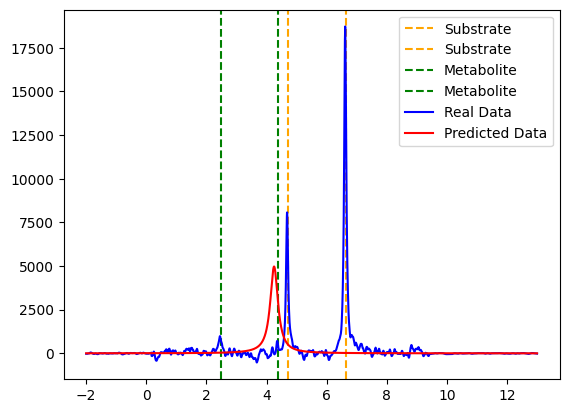

(1, 3000)


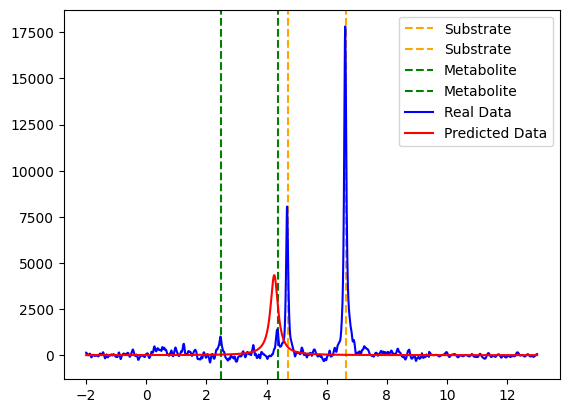

(1, 3000)


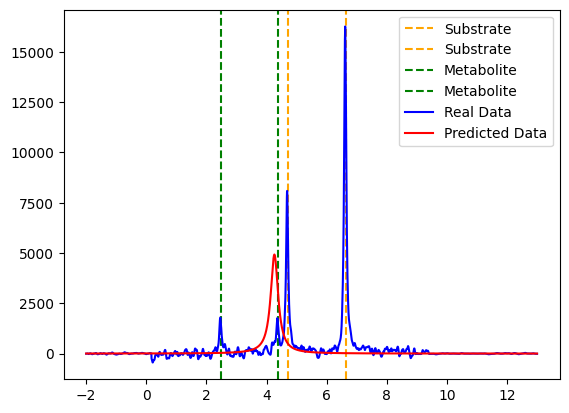

(1, 3000)


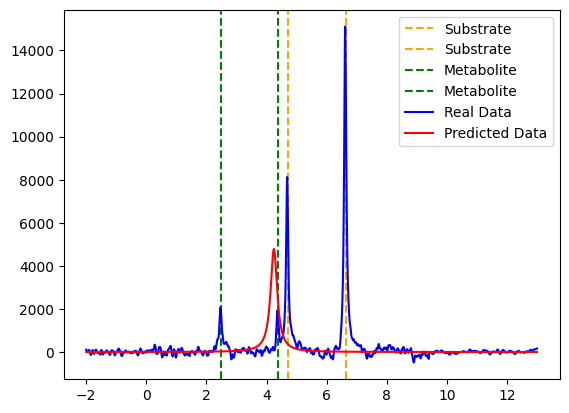

(1, 3000)


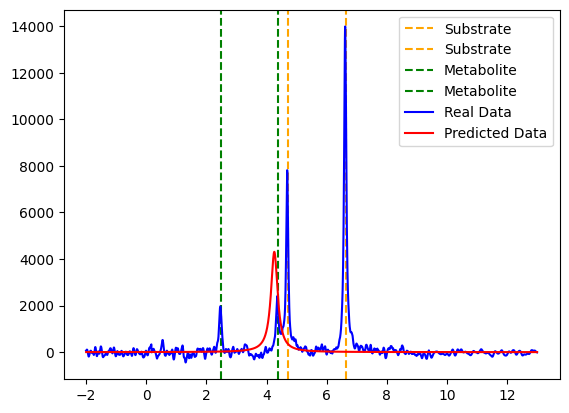

(1, 3000)


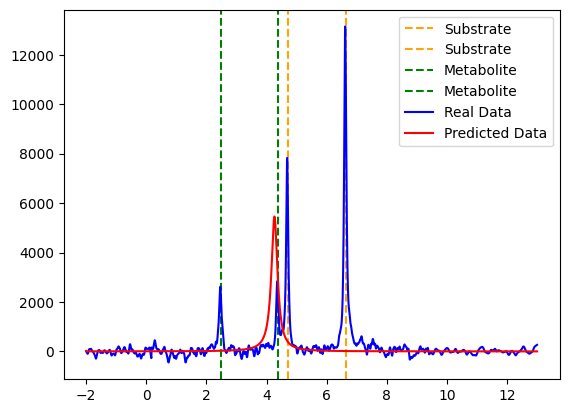

(1, 3000)


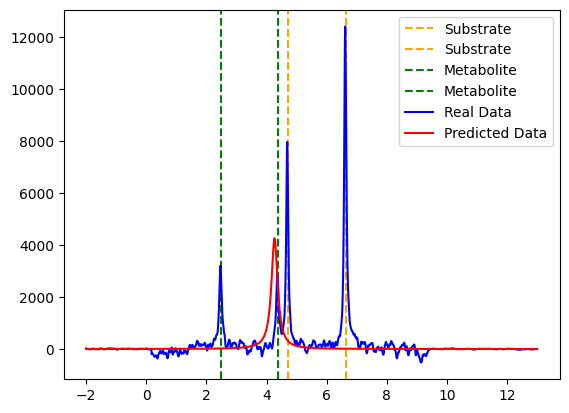

(1, 3000)


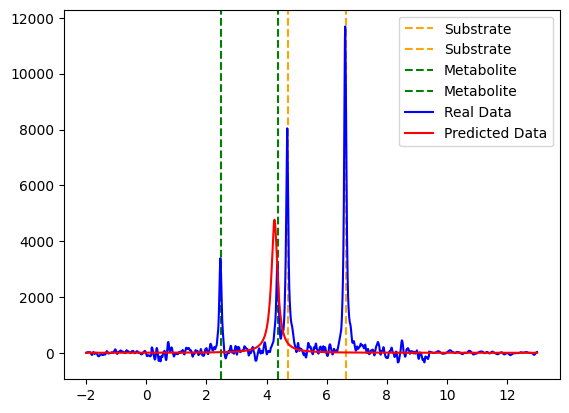

In [ ]:
df = pd.read_csv(path_list[0]) 

for i in range(1, 10):
    # fill the data
    df_fill = fill_df(df.iloc[:, [0, i]])

    # interpolate the data
    df_interpolated = interpolate_to_shape(df_fill.iloc[:, 0], df_fill.iloc[:, 1], spectrum_lenth=3000)
    #display(df_interpolated)
    x_real = df_interpolated.loc[:, 'x']
    y_real = df_interpolated.loc[:, 'y']

    # scale the data
    y_real_sc = data_scaler.transform(y_real.values.reshape(1, -1))
    print(y_real_sc.shape)

    # convert to tensor
    y_real_tensor = torch.tensor(y_real_sc, dtype=torch.float32)

    # predict the data
    target_real_pred = model.predict(y_real_tensor)

    # bring the data back to the cpu
    target_real_pred = target_real_pred.cpu().detach().numpy()

    # rescale the data
    target_real_pred_rescaled = target_scaler.inverse_transform(target_real_pred)

    # reshape the data
    target_real_pred = target_real_pred_rescaled.reshape(target_real_pred_rescaled.shape[0], -1)

    x0_parms_real, gamma_parms_real, height_parms_real = np.split(target_real_pred, 3, axis=1)

    # calcualte the mse
    #mse = calculate_mse_of_real_data(df, model, random=False, i=i)
    #print(mse)
    
    # Put the Lorenz functions in a Dataframe
    lorentz_list = []
    lorentz_df = pd.DataFrame({'x': x_real})  # Initialize DataFrame with x_real

    for i, (x0, gamma, height) in enumerate(zip(x0_parms_real[0], gamma_parms_real[0], height_parms_real[0])):
        lorentz = lorentzian(x_real, x0, gamma, height)
        column_name = f'lorentz_{i}'  # Dynamically generate a unique column name
        lorentz_df = pd.concat([lorentz_df, pd.DataFrame({column_name: lorentz})], axis=1)

    # add another column which takes the np.maximum of the columns
    lorentz_df['max'] = lorentz_df.iloc[:, 1:].max(axis=1)
    #display(lorentz_df)
    


    for subs in substrates:
        plt.axvline(x=subs, color='orange', linestyle='--', label='Substrate')

    for metab in metabolites:
        plt.axvline(x=metab, color='green', linestyle='--', label='Metabolite')

    plt.plot(x_real, y_real, label='Real Data', color='blue')
    plt.plot(x_real, lorentz_df['max'], label='Predicted Data', color='red')


    plt.legend()
    plt.show()

In [ ]:
substrates, metabolites

([6.653, 4.7], [4.368, 2.474])